# **Step 1: Load and Preprocess Dataset**

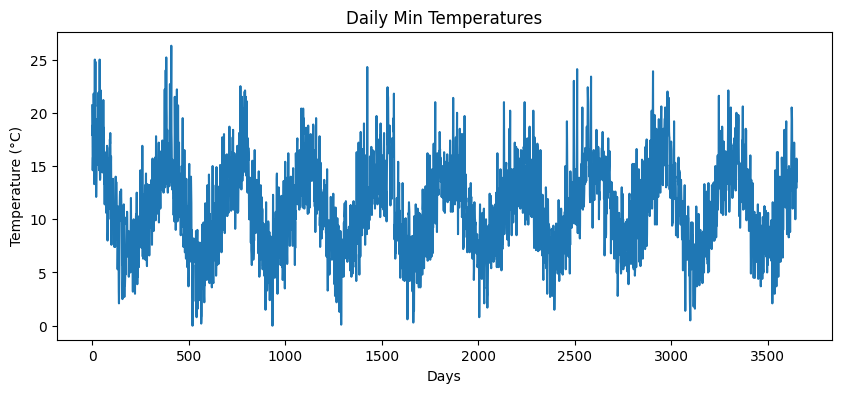

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset from CSV
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url, parse_dates=['Date'])

# Plot to visualize
plt.figure(figsize=(10, 4))
plt.plot(df['Temp'])
plt.title("Daily Min Temperatures")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.show()


# **Step 2: Prepare Data for RNN**

In [ ]:
# Convert to NumPy array
temps = df['Temp'].values.astype(np.float32)

# Normalize for better training
mean = temps.mean()
std = temps.std()
temps = (temps - mean) / std

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Create input/output sequences
window_size = 7  # Predict next day from previous 7 days
X, y = create_sequences(temps, window_size)

# Reshape for RNN input: (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train/test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# **Step 3: Build the RNN Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(64, return_sequences=True, activation='tanh', input_shape=(window_size, 1)),
    SimpleRNN(32, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 7, 64)          │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

# **Step 4: Train the Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5355 - val_loss: 0.3052
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3767 - val_loss: 0.2982
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3648 - val_loss: 0.2992
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3964 - val_loss: 0.2963
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3674 - val_loss: 0.3035
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3754 - val_loss: 0.2972
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3615 - val_loss: 0.2959
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3738 - val_loss: 0.2975
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3715 - val_loss: 0.2960
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3653 - val_loss: 0.2950
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3634 - val_loss: 0.3047
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3642 - val_lo

# **Step 5: Evaluate and Plot Predictions**

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


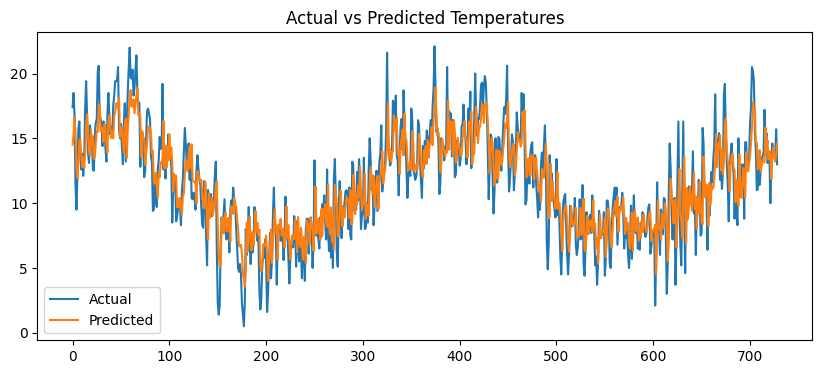

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_denorm = y_pred * std + mean
y_test_denorm = y_test * std + mean

# Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test_denorm, label='Actual')
plt.plot(y_pred_denorm, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Temperatures")
plt.show()
